LSTM method using this method as a source https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

tldr: Transform dataset into supervised method, make it stationary, transform to scale, LSTM

In [34]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

Alternative prediction using the last predicted value as the input. This is necessary because we want to predict more than one time unit ahead.

Lets try with another dataset

In [36]:
# load dataset
series = pd.read_csv('../cut/1000/train/Daily.csv').iloc[1,2:].dropna()
test_series = pd.read_csv('../cut/1000/test/Daily.csv').iloc[1,1:]

def scale2(train_data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_data)
    # transform train
    train = train_data.reshape(train_data.shape[0], train_data.shape[1])
    train_scaled = scaler.transform(train_data)
    return scaler, train_scaled

def make_predictions(lstm_model, train_scaled, scaler, raw_values):
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    scaled_predictions = list()
    predictions = list()
    X = train_scaled[-1,1:2]

    yhat = forecast_lstm(lstm_model, 1, X)
    scaled_predictions.append(yhat)
    
    yhat = invert_scale(scaler, X, yhat)
    yhat = yhat + raw_values[-1]
    predictions.append(yhat)
    
    for i in range(1, 14):
        X = np.array([scaled_predictions[-1]])
        yhat = forecast_lstm(lstm_model, 1, X)
        scaled_predictions.append(yhat)
        
        yhat = invert_scale(scaler, X, yhat)
        yhat = yhat + predictions[-1]
        predictions.append(yhat)
    
    print(scaled_predictions)
    print(predictions)

    return predictions
    

def create_model_and_predict(train_series):
    # transform data to be stationary
    raw_values = train_series.values
    diff_values = difference(raw_values, 1)

    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # transform the scale of the data
    scaler, train_scaled = scale2(train)

    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 100, 4)
    
    predictions = make_predictions(lstm_model, train_scaled, scaler, raw_values)
    return predictions

pred = create_model_and_predict(series)

[-0.048924938, -0.025193669, -0.011219692, -0.0038231304, -0.0001568608, 0.0015217755, 0.0022059493, 0.0024245502, 0.002443809, 0.002390217, 0.0023196312, 0.0022539701, 0.0021998724, 0.0021577002]
[7158.088141681925, 7154.968756677881, 7154.447623195425, 7155.301769437567, 7156.837603511587, 7158.685554804579, 7160.660718025938, 7162.6765268466625, 7164.6959164760265, 7166.705341400877, 7168.701641978994, 7170.685733976141, 7172.6597672126445, 7174.625959219709]


Test RMSE: 158.106


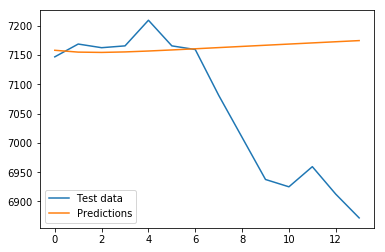

In [37]:
rmse = np.sqrt(mean_squared_error(test_series.values[-14:], pred[-14:]))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test_series.values[-14:], label="Test data")
plt.plot(pred[-14:], label="Predictions")
plt.legend()
plt.show()